# TRAINING MODELS

![Training Framework](img/train_framework.png "Training Framework")

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from fc_net import *
from solver import *
from layers import *
from utils.gradient_check import *
from utils.load_MNIST import *

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

# plot configuration
%matplotlib inline
plt.rcParams["figure.figsize"] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Data Preprocessing

These are the common forms of data preprocessing:
 * mean subtraction
 * normalization
 * PCA / Whitening

<b>Mean subtraction</b> involves subtracting the mean across every individual feature in the data, and has the geometric interpretation of centering the cloud of data around the origin across every dimension

<b>Normalization</b> refers to normalizing the data dimensions so that they are of approximately the same scale. One way is to divide each dimension by its standard deviation, once it has been zero-centered. Another way is to normalize so that the <i>min</i> and <i>max</i> along each dimension are -1 and 1 respectively.  
It only makes sense to apply this preprocessing if different input features have different scales, but should be of approximately equal importance.

![Data Preprocessing](img/train_data_preprocessing.png "Data Preprocessing")


### PCA and Whitening 

<b>Principal Component Analysis</b> uses an orthogonal transformation to convert the set of data points to a set of linearly uncorrelated variables called <b>principal components</b>. This transformation is defined in such a way that the first principal component has the largest possible varience, that is, it accounts for as much of the variability of the data as possible.  
In this process the data is first centered and after that the data covariance matrix is computed. The <i>(i, j)</i> entry of the data covariance matrix contains the covariance between the <i>i-th</i> and the <i>j-th</i> dimension of the data. Following, the SVD of the data covariance matrix is computed.

$$ cov = X^{T} X $$  
$$ cov = U \Sigma V^{T} $$  
$$ X_{rot} = X U $$  

The columns of $ U $ are a set of orthonormal vectors, so they can be regarded as basis vectors. To decolerate the data we project the original (zero-centered) data into the eigenbasis. The projection of $ X $ therefore corresponds to a rotation of the data so that the new axes are the eigenvectors. 
A nice property of SVD is that the eigenvectors in $ U $ are sorted by their eigenvalues. This can be used to reduce the dimensionality of the data by only using the top few eigenvectors and discarding the dimensions along which the data has no variance.

<b>The whitening</b> operation takes the data in the eigenbasis and divides every dimesion by the corresponding eigenvalue to normalize the scale.

![PCA Whitening](img/train_pca_whitening.png "PCA Whitening")

It should be pointed out that PCA and Whitening are only mentioned for completeness. These transformations are not used with Convolutional Neural Networks and more complex network architectures. However, zero-centering and normalization of the data are very important.

```python
# Decolerate the data.
cov_matrix = np.dot(X_train.T, X_train) / X_train.shape[0]
U, S, V = np.linalg.svd(cov_matrix)
X_train_rot = X_train.dot(U)
X_val_rot = X_val.dot(U)
X_test_rot = X_test.dot(U)

# Whiten the data.
X_train_white = X_train_rot / np.sqrt(S)
X_val_white = X_val_rot / np.sqrt(S)
X_test_white = X_test_rot / np.sqrt(S)
```


### NOTE

An important point is that any preprocessing statistic is only computed on the training data, and then applied to the validation and test data.  
Also, in case of images, the relative scales of pixels are already approximately equal (in the range [0, 255]), so it is not strictly necessary to perform normalization.

## BACKPROPAGATION

// Write something about backprop

In [2]:
# Write some code.

## Gradient Checks

Performing a gradient check is as simple as comparing the analytic gradient to the numeric gradient. The <i>centered difference</i> formula is used for the finite difference approximation.

$$ \displaystyle \frac{df(x)}{dx} = \frac{f(x+h) - f(x-h)}{2h} $$

The reason for using the centered difference formula instead of the standard difference quotient is that the error of the standard formula is of the order $ O(n) $, while the error of the centered formula is of the order $ O(n^{2}) $.

Comparing the analytic gradient with the numeric gradient is done using <i>relative error</i>, which consideres the ratio of the difference to the absolute value of the sum. Relative error of around <i>1e-7</i> should be satisfactory. However, for deep networks, the relative error will be higher. For example, for a 10-layer net a relative error as high as <i>1e-2</i> might be okay.

$$ \displaystyle \frac{|\nabla_{numeric} - \nabla_{analytic}|}{max(|\nabla_{numeric}, \nabla_{analytic})|} $$

The loss function is a sum of the data loss and the regularization loss. One danger is that the regularization loss may overwhelm the data loss, in which case the gradients will be primarily comming from the regularization term. This can mask an incorrect implementation of the data loss gradient. Therefore, the regularization is turned off and the data loss is checked alone.  
A particular random seed is forced before evaluating the numeric and analytic gradient in order to turn off the non-deterministic effects in the network (e.g. dropout).

In [3]:
# Write some code.

## Loss functions

The loss function has the form:

$$ \displaystyle L
= \underbrace{\frac{1}{N} \sum_{i=1}^{N}L_{i}}_{\text{data loss}}
+ \underbrace{\lambda R(W)}_{\text{regularization loss}} $$

where $ N $ is the number of training examples.

The data loss measures the compatibility between the predicted class scores and the ground truth label, and takes the form of an average over the data losses for every individual example.  
The loss will be high if we are doing a poor job, and it will be low if we are doing well.

In the case of classification we have a dataset of examples and a single correct label (out of a fixed set) for each example. The most common data loss functions in this setting are:
 * Cross-Entropy Loss
 * Hinge Loss

### Cross-Entropy Loss

One of the most common choices of a loss function is the cross-entropy loss.  
Assume a single example $ x_{i} $ is input in the model. The vector of predicted class scores $ s_{i} $ is fed to the <b>softmax function</b>:

$$ f(\vec{s_{i}})
= \begin{bmatrix} f(s_{i1}) \\ f(s_{i2}) \\ \vdots \\ f(s_{ic}) \end{bmatrix}
\small
= \begin{bmatrix}
\displaystyle\frac{e^{s_{i1}}}{\displaystyle\sum_{j=1}^{c} e^{s_{ij}}} \\
\displaystyle\frac{e^{s_{i2}}}{\displaystyle\sum_{j=1}^{c} e^{s_{ij}}} \\
\vdots \\
\displaystyle\frac{e^{s_{ic}}}{\displaystyle\sum_{j=1}^{c} e^{s_{ij}}}
\end{bmatrix}$$

where $ c $ is the number of classes.

This function takes a vector of arbitrary real-valued scores for each class and squashes it to a vector of values between zero and one, that sum to one. Effectively, it gives a probabilistic distribution over the classes. The resulting vector can be interpreted as a vector of the normalized probabilities assigned to each class.

The cross-entropy between a true distribution $ p $ and an estimated distribution $ q $ is defined as:

$$ H(p,q) = H(p) + D_{KL}(p||q) $$

In our case:  
$ p $ - the true distribution is the distribution where all probability mass is on the correct class (i.e. $ p = [0, \cdots, 0, 1, 0, \cdots, 0] $ contains a single 1 at the $ y_{i} $ <sup>-th</sup> position)  
$ q $ is the estimated distribution,
$ q =
\begin{bmatrix}
\displaystyle\frac{e^{s_{i1}}}{\displaystyle\sum_{j=1}^{c} e^{s_{ij}}} &
\displaystyle\frac{e^{s_{i2}}}{\displaystyle\sum_{j=1}^{c} e^{s_{ij}}} &
\cdots &
\displaystyle\frac{e^{s_{ic}}}{\displaystyle\sum_{j=1}^{c} e^{s_{ij}}}
\end{bmatrix}$  
$ H(p) $ is the entropy of $ p $ and is equal to zero  
$ \displaystyle D_{KL}(p||q) = - \sum_{x} p(x)logq(x) $ is the Kullback-Leibler divergence between the two distributions

The cross-entropy thus becomes:

$$ \displaystyle H(p,q) = - \sum_{x} p(x)logq(x)
= -log \left( \frac{e^{s_{i, y_{i}}}}{\displaystyle\sum_{j} e^{s_{ij}}} \right) $$

and the loss for example $ x_{i} $ is:

$$ \displaystyle L_{i} = -log \left( \frac{e^{s_{i, y_{i}}}}{\displaystyle\sum_{j=1} e^{s_{ij}}} \right)
= - s_{i, y_{i}} + log \sum_{j=1}^{c} e^{s_{ij}} $$

It should be noted that in practice the terms $ e^{s_{y_{i}}} $ and $ \displaystyle\sum_{j} e^{s_{j}} $ might be very large, and performing division might be numerically unstable. To deal with this problem the following trick is performed:

$$ \displaystyle
\frac{e^{s_{i, y_{i}}}}{\displaystyle\sum_{j} e^{s_{ij}}}
= \frac{B e^{s_{i, y_{i}}}}{B \displaystyle\sum_{j} e^{s_{ij}}}
= \frac{e^{s_{i, y_{i}} + log B}}{\displaystyle\sum_{j} e^{s_{ij} + log B}} $$

We can choose $ B $ freely ($ B \neq 0 $) and this will not change any of the results. We can improve the numerical stability of the computation by choosing:

$$ log B = -\underset{j}{max} f_{j} $$

Computing the derivative of $ L $ with respect to the predicted class scores $ s $ amounts to computing:

$$ \displaystyle \frac{\partial L}{\partial s_{ij}} $$

for $ 1 \leq i \leq N $ and $ 1 \leq j \leq C $.

$$ \displaystyle
\frac{\partial L}{\partial s_{ij}}
= \frac{1}{N} \sum_{k=1}^{N} \frac{\partial L_{k}}{\partial s_{ij}}
= \frac{1}{N} \frac{\partial L_{i}}{\partial s_{ij}}
= \frac{e^{s_{ij}}}{\displaystyle\sum_{k=1}^{c} e^{s_{ik}}} - \underbrace{1_{[y_{i} = j]}}_{\text{1 if the correct class of i is j}}
$$

In [4]:
# Example forward and backward pass.
np.random.seed(0)

num_examples = 3
num_classes = 5
scores = np.random.randn(num_examples, num_classes) * 5
labels = np.random.randint(low=0, high=num_classes, size=num_examples)

np.set_printoptions(precision=3)
print("scores:\n", scores)
print("labels:\n", labels)

Y = np.log(np.sum(np.exp(scores), axis=1, keepdims=True))           # log of sum of exp
Z = scores - Y                                                      # compute log(sum(exp(s_ik))) - s_ij, for all i,j
loss = - np.sum(Z[np.arange(num_examples), labels]) / num_examples  # sums only the relevant terms
print("loss:\n %.3f" % loss)

grads = np.exp(Z)                                                   # effectively compute the 1st part of the derivative
grads[np.arange(num_examples), labels] -= 1                         # computes the 2nd part of the derivative
grads /= num_examples
print("grads:\n", grads)

scores:
 [[ 8.82   2.001  4.894 11.204  9.338]
 [-4.886  4.75  -0.757 -0.516  2.053]
 [ 0.72   7.271  3.805  0.608  2.219]]
labels:
 [2 3 0]
loss:
 6.155
grads:
 [[ 2.460e-02  2.687e-05 -3.328e-01  2.669e-01  4.128e-02]
 [ 2.021e-05  3.096e-01  1.256e-03 -3.317e-01  2.086e-02]
 [-3.329e-01  3.204e-01  1.001e-02  4.093e-04  2.049e-03]]


In [5]:
# Check the backward pass.
loss, grads = cross_entropy_loss(scores, labels)

f = lambda X: cross_entropy_loss(X, labels)[0]
grads_num = eval_numerical_gradient(f, scores, verbose=False)

print("max relative error: %e" % (rel_error(grads_num, grads)))

max relative error: 2.064583e-06


### Hinge Loss

Another very common choice for loss function is the hinge loss. Given the raw output scores, $ s_{1}, s_{2}, \cdots, s_{C} $, of the classifier, the Weston and Watkins definition of the multiclass hinge loss is the following:

$$ \displaystyle L_{i} = \sum_{j \neq y_{i}} max(0, s_{j} - s_{y_{i}} + \Delta) $$

The function is set up so that the correct class to have a score higher than the incorrect classes by some margin $ \Delta $.  
If the correct class score is greater than an incorrect class score by at least the margin, then we get zero loss for this pair. Even if the difference is much greater than the margin the result is still the same.  
If the correct class score is not greater than an incorrect class score by the desired margin we accumulate loss, even though the correct class has higher score.

When using regularization over the weights with parameter $ \lambda $, the two parameters $ \Delta $ and $ \lambda $ control the same tradeoff since the magnitude of the weights has a direct effect on the scores (and hence on their differences). The exact value of the margin between the scores is meaningless because the weights can shrink or stretch the differences arbitrarily. Thus, it is safe to set $ \Delta = 1 $ and tune only the hyperparameter $ \lambda $.

Thus, for the data loss we obtain:

$$ \displaystyle L = \frac{1}{N} \sum_{i=1}^{N} \sum_{j \neq y_{i}} max(0, s_{ij} - s_{iy_{i}} + 1) $$

Computing the derivative of $ L $ with respect to the predicted class scores $ s $ amounts to computing:

$$ \displaystyle \frac{\partial L}{\partial s_{ij}} $$

for $ 1 \leq i \leq N $ and $ 1 \leq j \leq C $.


$$ \displaystyle
\frac{\partial L}{\partial s_{ij}}
= \frac{1}{N} \displaystyle\sum_{k=1}^{N} \frac{\partial L_{k}}{\partial s_{ij}}
= \frac{1}{N} \frac{\partial L_{i}}{\partial s_{ij}}
$$  

In case $ j = y_{i} $ we have:

$$ \displaystyle \frac{\partial L_{i}}{\partial s_{ij}} = - \sum_{k} \mathbb{1}_{\{s_{ik} - s_{iy_{i}} + 1 > 0\}}
$$


In case $ j \neq y_{i} $ we have:

$$ \displaystyle \frac{\partial L_{i}}{\partial s_{ij}} = \mathbb{1}_{\{s_{ij} - s_{iy_{i}} + 1 > 0\}} $$



..


$$ \displaystyle
\frac{\partial L_{i}}{\partial s_{ij}} =
\begin{cases}
& \mathbb{1}_{\{s_{ij} - s_{iy_{i}} + 1 > 0\}} \text{if $ j \neq y_{i} $} \\
& - \sum_{k} \mathbb{1}_{\{s_{ik} - s_{iy_{i}} + 1 > 0\}}
\end{cases}
$$

In [6]:
# Example forward and backward pass.
np.random.seed(0)

num_examples = 3
num_classes = 5
scores = np.random.randn(num_examples, num_classes) * 5
labels = np.random.randint(low=0, high=num_classes, size=num_examples)

np.set_printoptions(precision=3)
print("scores:\n", scores)
print("labels:\n", labels)

correct_class_scores = scores[np.arange(num_examples), labels]
print("correct class scores:\n", correct_class_scores)

margins = np.maximum(0, scores - correct_class_scores[:, np.newaxis] + 1)
margins[np.arange(num_examples), labels] = 0
print("margins:\n", loss)
loss = (np.sum(margins))/num_examples
print("loss:\n %.3f" % loss)

grads = (margins > 0).astype(float)
grads[np.arange(num_examples), labels] = -np.sum(grads, axis=1)
grads /= num_examples
print("grads:\n", grads)

scores:
 [[ 8.82   2.001  4.894 11.204  9.338]
 [-4.886  4.75  -0.757 -0.516  2.053]
 [ 0.72   7.271  3.805  0.608  2.219]]
labels:
 [2 3 0]
correct class scores:
 [ 4.894 -0.516  0.72 ]
margins:
 6.154662940512586
loss:
 14.433
grads:
 [[ 0.333  0.    -1.     0.333  0.333]
 [ 0.     0.333  0.333 -1.     0.333]
 [-1.333  0.333  0.333  0.333  0.333]]


In [7]:
# Check the backward pass.
loss, grads = hinge_loss(scores, labels)

f = lambda X: hinge_loss(X, labels)[0]
grads_num = eval_numerical_gradient(f, scores, verbose=False)

print("max relative error: %e" % (rel_error(grads_num, grads)))

max relative error: 1.965645e-10


### Softmax vs Max-Margin

The difference between the two functions is that the Softmax is always looking for the "true" probability distribution and might optimize endlessly, while Max-Margin stops when the correct class score achieves the desired margin over the other scores.

The softmax function is used when we need a probability distribution over the classes, while the max-margin function is used when one of the classes has to stand out from the others.

One advantage of using the max-margin function is that if a new class is added to the model, after the model has been trained, the optimization process for further training will be very fast.

## Regularization

As we increase the complexity of a model, the capacity increases. <b>Overfitting</b> occurs when a model with high capacity fits the noise in the data instead of the underlying relationship. This leads to reduced generalization on the test set.  
It may seem that a simpler model can be preferred if the data is not too complex to prevent overfiting. However, this is incorrect. There are many other ways to prevent overfitting and in practice it is always better to use these methods instead. The regularization strength is the preffered way to control overfitting.

### L2 Regularization

<b>L2 regularization</b> is perhaps the most common form of regularization. It is implemented by penalizing the squared magnitude of all weights directly in the objective.

$$ \displaystyle L = \frac{1}{N} \sum_{i}L_{i} + \frac{1}{2} \lambda \sum_{i}\sum_{j} w_{i,j}^{2} $$

where $ \lambda $ is the regularization strength.  
The L2 regularization has the intuitive property of heavily penalizing peaky weight vectors and preferring diffuse weight vectors encouraging the model to use all of its inputs a little rather than some of its inputs a lot. Penalizing large weights tends to improve generalization, because it means that no input dimension can have a very large influence on the scores all by itself.

Note that biases do not have the same effect since, unlike weights, they do not control the strength of influence of an input dimension. Thus, it is common to only regularize the weights $ W $ but not the biases $ b $. However, in practice this most likely turns out to have a negligible effect because there are very few bias terms compared to all the weights.

In [8]:
# write some code

## NEURAL NETWORKS

Neural network models are organized into distinct layers of neurons. For regular neural networks, the most common layer type is the <b>fully-connected layer</b> in which neurons between two adjecent layers are fully pairwise connected, but neurons within a single layer share no connections.

![Three Layer NN](img/nn_three_layer.png "Three Layer NN")

Each neuron performs a dot product with the input and its weights, adds the bias and applies an <b>activation function</b> $ f(x) $. Commonly used activation functons are:
 * Sigmoid: $ \sigma (x) = 1 \space / \space (1 + e^{-x}) $
 * Tanh: $ tanh(x) = (e^{x} - e^{-x}) \space / \space (e^{x} + e^{-x}) $
 * ReLU: $ f(x) = max(0, x) $

![Activation Functions](img/nn_activation_fnc.png "Activation Functions")

<b>The sigmoid function</b> has seen frequent use historically, but in practice has recently fallen out of favor and it is rarely ever used. A very undesirable property of the sigmoid neuron is that when the neron's activation saturates at either 0 or 1, the gradient at these regions is almost zero (the graphic of the function is flat at these regions). Therefore, this will effectively "kill" the gradient amd almost no signal will flow through the neuron to its weights and recursively to its data. Another undesireable property is that the outputs of the sigmoid neurons are <i>not zero-centered</i> and the neurons in later layers would be recieving only positive data. If the data coming into a neuron is always positive, then the gradient during backpropagation will either be positive for all weights, or negative for all weights. However, adding up the gradients across a batch of data somewhat mitigates this issue.

<b>The tanh</b> function, like the sigmoid, saturates and "kills" the gradient, but unlike the sigmoid its output is zero-centered. In practice tanh is <i>always preferred over the sigmoid</i>.

<b>The Rectified Linear Unit</b> is the most widely used activation function. It was found to greatly accelerate the convergence of stochastic gradient descent compared to the sigmoid/tanh functions and is a relatively inexpensive mathematical operation. A drawback is that a ReLU neuron could cause the weights to update in such a way that the neuron will never activate on any datapoint again. That is, ReLU neurons <i>could irreversibly die</i> during training, but with a proper setting of the learning rate this is less frequently an issue. <i>Leaky ReLU</i> is one attempt to fix the "dying ReLU" problem.

Note that the non-linearity is critical computationally - if we left it out, all matrix multiplications during the forward pass could be collapsed to a single matrix, and therefore the predicted class scores would be a linear function of the input.

It is very rare to mix different types of neurons in the same network, even though there is no fundamental problem with doing so.

Unlike all layers in a neural network, the output layer neurons do not have an activation function. The last output layer is taken to represent the class scores which are arbitrary real-valued numbers.

In practice it is often the case that three-layer neural networks will outperform two-layer nets, but going even deeper (4-, 5-, 6-layer) rarely helps much more.

### Dropout 
<b>Dropout</b> is an extremely effective regularization technique introduced by Srivastava et. al. in <i>Dropout: A Simple Way to Prevent Neural Networks from Overfiting</i>. During training dropout is implemented by only keeping a neuron active with some probability <i>p</i>, or setting it to zero otherwise. The parameter <i>p</i> can be chosen using hyperparameter tuning or can simply be set to 0.5. The paper states that the value 0.5 seems to be close to the optimal for a wide range of networks and tasks.

Dropout is applied after all hidden layers with probability <i>p = 0.5</i>. It is also possible to perform dropout right on the input layer, however, the paper states that the optimal probability for retention of the input units is usually closer to 1.

![Dropout](img/nn_dropout.png "Dropout")

Let <i>z<sup>(l)</sup></i> denote the vector of inputs to layer <i>l</i>, <i>y<sup>(l)</sup></i> denote the vector of outputs to layer <i>l</i>, and <i>W<sup>(l)</sup></i> and <i>b<sup>(l)</sup></i> denote the weights and biases of layer <i>l</i>. The feed-forward operation of a standard neural network can be described as:

$$ z^{(l+1)} = y^{(l)}W^{(l+1)} + b^{(l+1)} $$  
$$ y^{(l+1)} = f(z^{(l+1)}) $$

where $ f $ is the activation function of the neurons.  
With dropout the feed-forward operation becomes:

$$ r^{(l)} \sim Bernouli(p) $$  
$$ \bar{y}^{(l)} = r^{(l)} * y^{(l)} $$  
$$ z^{(l+1)} = \bar{y}^{(l)}W^{(l+1)} + b^{(l+1)} $$  
$$ y^{(l+1)} = f(z^{(l+1)}) $$

![Dropout Network](img/nn_dropout_network.png "Dropout Network")

Applying dropout to a neural network ammounts to sampling a "thinned" network that consists of all the units that survived dropout. A neural network with <i>n</i> units can be seen as a collection of <i>2<sup>n</sup></i> neural networks that all share weights and the prediction is the average of all networks from the ensamble. Training a neural network with dropout can be seen as training that collection of <i>2<sup>n</sup></i> neural networks, where each network gets trained very rarely, if at all.  
However, performing this explicit averaging at test time is not feasible. A very simple approximate averaging method works well in practice. We want the outputs of neurons at test time to be identical to their expected outputs at training time.  
The idea is to use a single neural net at test time without dropout and a scaled-down version of the trained weights. If a unit is retained with probability <i>p</i> during training, the outgoing weights of that unit are multiplied by <i>p</i> at test time. This ensures that for any hidden unit the <i>expected</i> output is the same as the actual output at test time.

![Dropout Averaging](img/nn_dropout_averaging.png "Dropout Averaging")

The scaling of the weights could also be performed at training time, thus, leaving the forwards pass at test time unchanged. This technique is sometimes called <b>inverse  dropout</b>. It also has the appealing property of leaving the prediction code unchanged and we can easily deside weather to apply dropout or not.

In [9]:
# Initialize random Gaussian data.
np.random.seed(0)
num_examples = 20
input_dim = 50
num_classes = 10

X_toy = np.random.randn(num_examples, input_dim)
y_toy = np.random.randint(low=1, high=num_classes, size=num_examples)

In [10]:
# Check the forward pass.
for p in [0.25, 0.4, 0.7]:
    out, _ = dropout_forward(X_toy, {"mode": "train", 'p': p})
    out_test, _ = dropout_forward(X_toy, {"mode": "test", 'p': p})
    print("Running tests with p = ", p)
    print("Fraction of train-time output set to zero: ", (out == 0).mean())
    print()

Running tests with p =  0.25
Fraction of train-time output set to zero:  0.751

Running tests with p =  0.4
Fraction of train-time output set to zero:  0.595

Running tests with p =  0.7
Fraction of train-time output set to zero:  0.31



In [11]:
# Check the backward pass.
# Initialize a neural network with dropout.
np.random.seed(0)
hidden_dims = [25, 25, 25]
nn_model = NeuralNetwork(hidden_dims, input_dim, num_classes,
                         dropout=0.5,   # dropout
                         weight_scale="Kaiming",
                         nonlinearity="relu",
                         dtype=np.float64,
                         seed=0) # deterministic dropout


# Using numeric gradient checking to check the implementation of the backward pass.
# If the implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of the model parameters.
loss, _grads = nn_model.loss(X_toy, y_toy)

# These should all be less than 1e-8 or so.
for _name in _grads:
    f = lambda W: nn_model.loss(X_toy, y_toy)[0]
    _grad_numeric = eval_numerical_gradient(f, nn_model.params[_name], verbose=False)
    print("%s max relative error: %e" % (_name, rel_error(_grad_numeric, _grads[_name])))

W4 max relative error: 6.782477e-03
b4 max relative error: 6.626049e-09
W3 max relative error: 1.036884e-05
b3 max relative error: 4.549665e-08
W2 max relative error: 1.658225e-05
b2 max relative error: 1.680862e-07
W1 max relative error: 4.950371e-07
b1 max relative error: 2.616936e-09


## Parameter update

Once the analytic gradient is computed with backpropagation, the gradients are used to perform parameter update.

<b>Vanilla update</b>. The simplest form of update is to simply change the parameters along the negative gradient direction using some scaling factor.

$$ W = W - \alpha \space dW $$

where $ \alpha $ is the learning rate.  
When evaluated on the full dataset, and when the learning rate is low enough, this is guaranteed to make non-negative progress on the loss function.

<b>Momentum update</b>. This is another approach that almost always achieves better converge rates on deep neural nets. Looking from a physical perspective the loss can be interpreted as the potential energy of a particle placed at a hilly terrain. The optimization process can be seen as simulating the rolling motion of the particle with zero initial velocity and optimizing the potential energy.  
The negative gradient now influences the velocity (a new variable) and the velocity in turn has an effect on the parameters:


$$
\begin{align*}
& V = V - \alpha \space dW \\
& W = W + V
\end{align*}
$$

The problem with this setting is that when the gradient is zero (the particle is on a flat surface) the parameters will continue updating indefinitely. To fix the problem an additional hyperparameter is introduced:

$$
\begin{align*}
& V = \mu V - \alpha \space dW \\
& W = W + V
\end{align*}
$$

The meaning of the coefficient $ \mu $ is to damp the velocity and is usually set to values such as $ [0.5, 0.9, 0.95, 0.99] $. A typical setting is to start with a value of about 0.5 and anneal it to 0.99 over multiple epochs.  
Often this coefficient is refferd to as <i>momentum</i> eventhough its physical meaning is more consistent with the coefficient of friction ( $ 1 - \mu $ is actually the friction coefficient).

<b>Nesterov momentum</b> is a slightly different version of the momentum update. The idea is to "peek ahead" at the candidate parameters $ W\_ahead = W + \mu V $ - that is the parameters we would get if we only followed the momentum, and evaluate the gradient of the objective with respect to $ W\_ahead $. We update the speed variable with the gradient $ dW\_ahead = d(W + \mu V) $, and finally we update the parameters:

$$
\begin{align*}
& V = \mu V - \alpha \space d(W + \mu V) \\
& W = W + V
\end{align*}
$$

The only difference is the evaluation point of the gradient. This important difference counterbalances too high velocities by "peeking ahead" at the objective values in the candidate search direction.

The problem with this formulation of the Nesterov Momentum Update is that now we have to compute the gradient $ d(W + \mu V) $. However, in practice it is prefered to express the update to be as similar to vanilla SGD as possible. In particular, we want to perform the update using the gradient $ dW $. To do that there is a simple trick: we have to commit to the peeked parameters $ W_{t} = W_{t} + \mu V_{t} $ and at the next iteration backtrack by the same amount.

$$ \displaystyle V_{t+1} = \underbrace{\mu V_{t} - \alpha \space dW_{t}}_{\text{perform update}} \quad $$  

note that $ dW_{t}$ is the gradient of the objective with respect to the candidate parameters

$$ \displaystyle W_{t+1} = \underbrace{\underbrace{\underbrace{W_{t} - \mu V_{t}}_{\text{backtrack}} + \mu V_{t+1}}_{\text{commit}} + V_{t+1}}_{\text{update}} $$

In [12]:
# Write some code

## Parameter update with per-parameter learning rates

All previous approaches manipulated the learning rate globally and equally for all parameters. Much work has gone into devising methods that can adaptively tune the learning rates per parameter.

<b>Adagrad</b> is an adaptive learning rate method proposed by Duchi et. al. in the paper <i>Adaptive Subgradient Methods for Online Learning and Stochastic Optimization</i>. The algorithm keeps track of the sum of the squared gradients, which is used to normalize the parameter update step element-wise:

$$ \displaystyle
\begin{align*}
& cache = cache + dW^{2} \\
& W = W - \frac{\alpha dW}{\sqrt{cache} + \epsilon}
\end{align*}
$$

Weights that recieve high gradients will have their effective learning rate reduced, while weights that recieve small or infrequent updates will have their effective learning rate increased.  
The term $ \epsilon $ is used to avoid division by $ 0 $.  
A downside is that the effective learning rate monotonically decreases and at some point learning stops completely.

<b>RMSProp</b> is very similar to Adagrad. It adjusts the algorithm in a very simple way. Instead of storing the sum of the squared gradients, it keeps a moving average of the squared gradients:


$$ \displaystyle
\begin{align*}
& cache = \mu * cache + (1 - \mu) * dW^{2} \\
& W = W - \frac{\alpha dW}{\sqrt{cache} + \epsilon}
\end{align*}
$$

Here $ \mu $ is the rate of decay. It is a hyperparameter with typical values [0.9, 0.99, 0.999].  
Like Adagrad, RMSProp modulates the learning rate of each weight based on the magnitudes of the gradients. Unlike Adagrad, the cache variable is "leaky", hence, the updates do not get monotonically smaller.

<b>Adam</b> was proposed by Kingma and Ba in their paper <i>Adam: A Method for Stochastic Optimization</i>. The algorithm looks a bit like RMSProp with momentum:

$$ \displaystyle
\begin{align*}
& m = \beta_{1} m + (1 - \beta_{1}) dW \\
& v = \beta_{2} v + (1 - \beta_{2}) dW^{2} \\
& W = W - \frac{\alpha m}{\sqrt{v} + \epsilon}
\end{align*}
$$

The update looks exactly as RMSProp, except that the running average $ m $ of the gradient is used, instead of the gradient itself.  
The full Adam update also includes a bias correction mechanism, which compensates for the fact that in the first few time steps the vectors $m, v$ are both biased at zero.

$$ \displaystyle
\begin{align*}
& m = \beta_{1} m + (1 - \beta_{1}) dW \\
& mt = \frac{m}{1 - \beta^{t}} \\
& v = \beta_{2} v + (1 - \beta_{2}) dW^{2} \\
& vt = \frac{v}{1 - \beta^{t}} \\
& W = W - \frac{\alpha mt}{\sqrt{vt} + \epsilon}
\end{align*}
$$

In practice Adam is the recommended default algorithm to use. Recommended values for the hyperparameters are: $ \epsilon = 1e-8 $, $ \beta_{1} = 0.9 $, $ \beta_{2} = 0.999 $. It should be noted that the update is now a function of the iteration as well as the other parameters.

In [13]:
# Write some code

## Training history

Some useful quantities are monitored during training of the model. These plots are the window into the training process and give insight into how different hyperparameters should be changed for more efficient learning.
 * Loss function - the plot of the loss function could be used to infer information about the learning rate of the model. Sometimes it is better to plot the loss function in the log domain. The plot of a reasonable loss appears as a slightly more interpretable straight line, rather than a hockey stick. Also, if multiple cross-validated models are plotted on the same loss graph, the differences between them become more apparent.
 * Train/Val accuracy - the training/validation accuracy plot gives valuable information about the amount of overfitting of the model. If the validation error curve shows very small validation accuracy compared to the training accuracy, this indicates that the model is overfitting the training data. If the validation accuracy tracks the training accuracy fairly well, then the model capacity is not high enough.
 * Update magnitudes to value magnitudes ratio - This ratio is evaluated and tracked for every set of parameters independently. A rough heuristic is that this ratio should be somewhere around 1e-3. If it is lower than this then the learning rate might be too low, if it is higher - the learning rate might be too high. Given a tensor of weights one could track the min or the max, but the most common way is to compute the norm.

$$ \displaystyle ratio = \frac{||-\alpha \space dW||}{||W||} $$

![Training Plots](img/train_plots.png "Training Plots")

 * When one is working with image pixels it can be helpful to plot the first-layer features visually. Noisy features could indicate uncoverged network, improperly set learning rate or very low weight regularization penalty. Nice, smooth, clean and diverse features are a good indication that the training is proceeding well.
 
![Visualized Weights](img/train_weight_vis.png "Visualized Weights")

In [14]:
# Wrtie some cde

## Hyperparameter Tuning

Neural networks involve many hyperparameter settings. The most common hyperparameters are:
 * initial learning rate
 * learning rate decay
 * regularization strength

There are many more relatively less sensitive hyperparameters.  
For tuning the hyperparameters the training set is split into a smaller training set and a <b>validation set</b>. The accuracy of the model is calculated on the validation set and the hyperparameters are tweaked to maximize the performance of the model.

In cases where the training set is small, a more sophisticated technique called <b>cross-validation</b> is used. For example, in k-fold cross-validation we split the training data into <i>k</i> equal folds, use <i>k - 1</i> of them for training, and 1 for validation. We would then iterate over which fold is the validation fold, and finally average the performance over the different folds. You can get a better and less noisy estimate of how well a given hyperparameter works by iterating over different validation sets and averaging over the performance across these.

In most cases a single validation set of respectable size substantially simplifies the code base, without the need for cross-validation with multiple folds. One validation fold is preferred to cross-validation.

The search for the hyperparameters <i>learning_rate</i> and <i>regularization_strength</i> is performed on a log scale. Intiutively, this is because learning rate and regularization strength have multiplicative effects on the training dynamics. Some parameters (e.g. dropout probability) are usually searched in the original scale.

Hyperparameter selection is more efficient when using radnom sampling rather than grid sampling as argued by Bergstra and Bengio in their paper <i>Random Search for Hyper-Parameter Optimization</i>. That is because the model as a function of the hyperparameters has a <i>low effective dimensionallity</i>, essentially it is more sensitive to changes in some dimensions than others. A grid of points gives even coverage in the original space, but produces inefficient coverage of the subspace. In contrast, random points are slightly less evenly distributed in the original space, but far more evenly distributed in the subspaces.

![Random Search](img/train_hyperparam.png "Random Search")

In [15]:
# Write some code

## Training on MNIST

We will train a three-layer fully-connected neural network on the MNIST dataset, that performs classification over the number of classes.  
The objective during training will be to minimize the cross-entropy loss between the true distribution and the estimated distribution.  
The network uses BatchNorm layers and ReLU nonlinearity for the first and second hidden layers.  
The regularization techniques used are dropout regularization after the first and second layers, and L2 regularization on the weight matrices.  
Parameter update is performed using Adam update rule.

The MNIST dataset can be downloaded from here:  
http://yann.lecun.com/exdb/mnist/  
https://www.python-course.eu/data/mnist/

The MNIST dataset is a dataset of handwritten digits. It has 60,000 training samples, and 10,000 test samples. Each image is represented by 28x28 pixels, each containing a value 0 - 255 with its grayscale value.

In [16]:
# Load preprocessed MNIST data.
mnist_dir = "datasets/MNIST/"
data = get_MNIST_data(mnist_dir, num_training=56000, num_validation=4000, num_test=10000,
                      zero_center=True, normalize=False, whiten=False)

for k, v in data.items():
    print("%s: " % k, v.shape)
    
image_size = data["X_train"].shape[1:]
num_classes = data["classes"].shape[0]
print("\nimage size:", image_size)
print("Number of classes:", num_classes)

X_train:  (56000, 28, 28)
y_train:  (56000,)
X_val:  (4000, 28, 28)
y_val:  (4000,)
X_test:  (10000, 28, 28)
y_test:  (10000,)
classes:  (10,)

image size: (28, 28)
Number of classes: 10


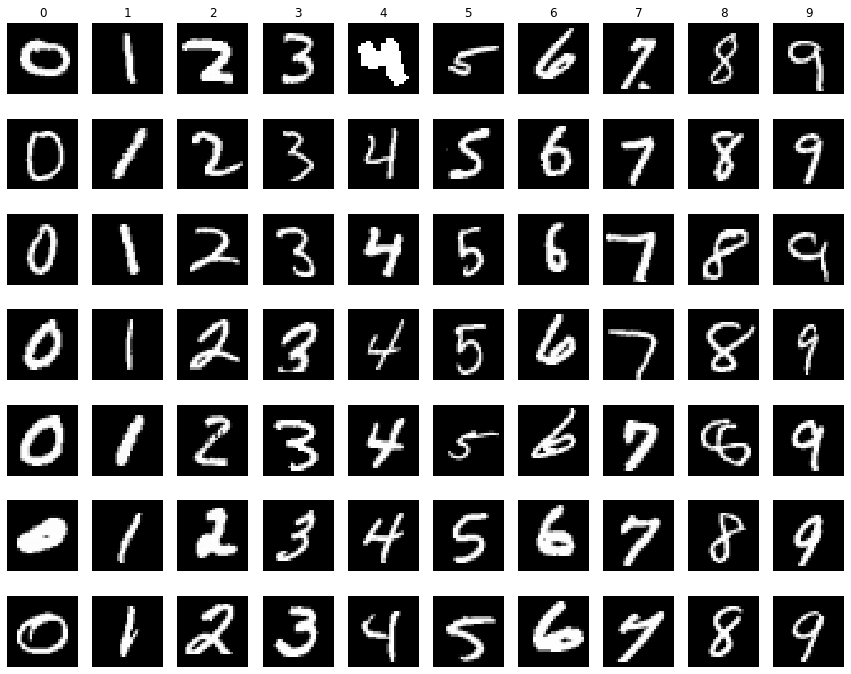

In [17]:
# Show a few examples of training images from each class.

# Reverse zero-centering for printing.
min_img = np.min(data["X_train"], axis=0)
img = data["X_train"] - min_img

# Visualize some examples from the dataset.
num_classes = len(data["classes"])
samples_per_class = 7

for y, cls in enumerate(data["classes"]):
    idxs = np.flatnonzero(data["y_train"] == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(img[idx].astype("uint8"))#, cmap="Greys")
        plt.axis("off")
        if i == 0:
            plt.title(cls)
plt.show()

del img

In [18]:
class MNIST_dataset(object):
    def __init__(self, data):
        """
        Inputs:
        - data: A dictionary of training and validation data containing:
          "X_train": A numpy array of shape (N_train, d_1, ..., d_k) of training examples
          "X_val": A numpy array of shape (N_val, d_1, ..., d_k) of validation examples
          "y_train": A numpy array of shape (N_train, ) of labels for training examples
          "y_val": A numpy array of shape (N_val, ) of labels for validation examples
        """
        self.data = data

    def train_batch(self, batch_size=-1):
        """
        Inputs:
        - batch_size: Integer, giving the size of the batch to be generated.
        
        Returns:
        - X_batch: A numpy array of shape (batch_size, d1, ..., dk) of training examples.
        - y_batch: A numpy array of shape (batch_size, ) of labels for training examples.
        """
        num_train = self.data["X_train"].shape[0]
        batch_mask = np.random.choice(num_train, batch_size)
        X_batch = self.data["X_train"][batch_mask]
        y_batch = self.data["y_train"][batch_mask]

        return X_batch, y_batch

    def val_batch(self, batch_size=-1):
        """
        Inputs:
        - num_val: Integer, giving the size of the batch to be generated.
          If num_val = -1, the entire validation set is returned.
        
        Returns:
        - X_batch: A numpy array of shape (batch_size, d1, ..., dk) of validation examples.
        - y_batch: A numpy array of shape (batch_size, ) of labels for validation examples.
        """
        return self.data["X_val"][:batch_size], self.data["y_val"][:batch_size]

    def num_train(self):
        """
        Returns:
        - num_train: Integer, giving the number of training examples in the dataset.
        """
        return self.data["X_train"].shape[0]

    def num_val(self):
        """
        Returns:
        - num_val: Integer, giving the number of validation examples in the dataset.
        """
        return self.data["X_val"].shape[0]

In [19]:
# Initialize the dataset.
dataset = MNIST_dataset(data)

# Initialize the network.
input_dim = np.prod(image_size)
hidden_dims = [200, 200]
nn_model = NeuralNetwork(hidden_dims, input_dim, num_classes,
                         weight_scale=1e-3, reg=1e-4, dropout=0.75,
                         normalization="batchnorm",
                         nonlinearity="relu",
                         dtype=np.float64)

In [20]:
nn_solver = SupervisedSolver(nn_model, dataset,
                             update_rule="adam",
                             optim_config={"learning_rate":1e-3},
                             lr_decay=0.1,
                             batch_size=128,
                             num_epochs=3,
                             print_every=100,
                             verbose=True)

tic = time.time()
nn_solver.train()
toc = time.time()
print("training took %.1f seconds" % (toc - tic))

Number of iterations per epoch: 437
(Iteration 0 / 1311) loss: 2.32282
(Epoch 0 / 3) train acc: 0.306750; val_acc: 0.341335
(Iteration 100 / 1311) loss: 1.37253
(Iteration 200 / 1311) loss: 0.84646
(Iteration 300 / 1311) loss: 0.64119
(Iteration 400 / 1311) loss: 0.48978
(Epoch 1 / 3) train acc: 0.960000; val_acc: 0.968992
(Iteration 500 / 1311) loss: 0.34055
(Iteration 600 / 1311) loss: 0.41473
(Iteration 700 / 1311) loss: 0.38256
(Iteration 800 / 1311) loss: 0.31670
(Epoch 2 / 3) train acc: 0.965000; val_acc: 0.974244
(Iteration 900 / 1311) loss: 0.31022
(Iteration 1000 / 1311) loss: 0.33756
(Iteration 1100 / 1311) loss: 0.30956
(Iteration 1200 / 1311) loss: 0.44638
(Iteration 1300 / 1311) loss: 0.38790
(Epoch 3 / 3) train acc: 0.962000; val_acc: 0.973993
training took 29.8 seconds


In [21]:
# Predict on the training and the validation set.
train_acc = nn_solver.check_accuracy(data["X_train"], data["y_train"])
val_acc = nn_solver.check_accuracy(data["X_val"], data["y_val"])
print("Train accuracy: %.5f" % train_acc)
print("Validation accuracy: %.5f" % val_acc)

# Predict on the test set.
test_acc = nn_solver.check_accuracy(data["X_test"], data["y_test"])
print("Test accuracy: %.5f" % test_acc)

Train accuracy: 0.96284
Validation accuracy: 0.97450
Test accuracy: 0.96070


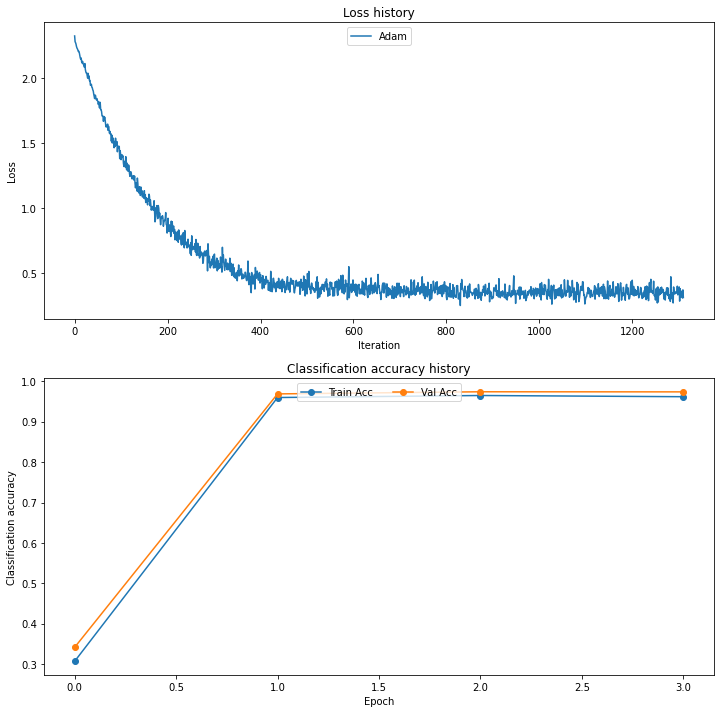

In [22]:
# Plot the loss functions and train / validation accuracies.
plt.subplot(2, 1, 1)
plt.plot(nn_solver.loss_history, label="Adam")
plt.legend(loc="upper center", ncol=1)
plt.title("Loss history")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.subplot(2, 1, 2)
plt.plot(nn_solver.train_acc_history, "-o", label="Train Acc")
plt.plot(nn_solver.val_acc_history, "-o", label="Val Acc")
plt.legend(loc="upper center", ncol=2)
plt.title("Classification accuracy history")
plt.xlabel("Epoch")
plt.ylabel("Classification accuracy")

plt.gcf().set_size_inches(12, 12)
plt.show()

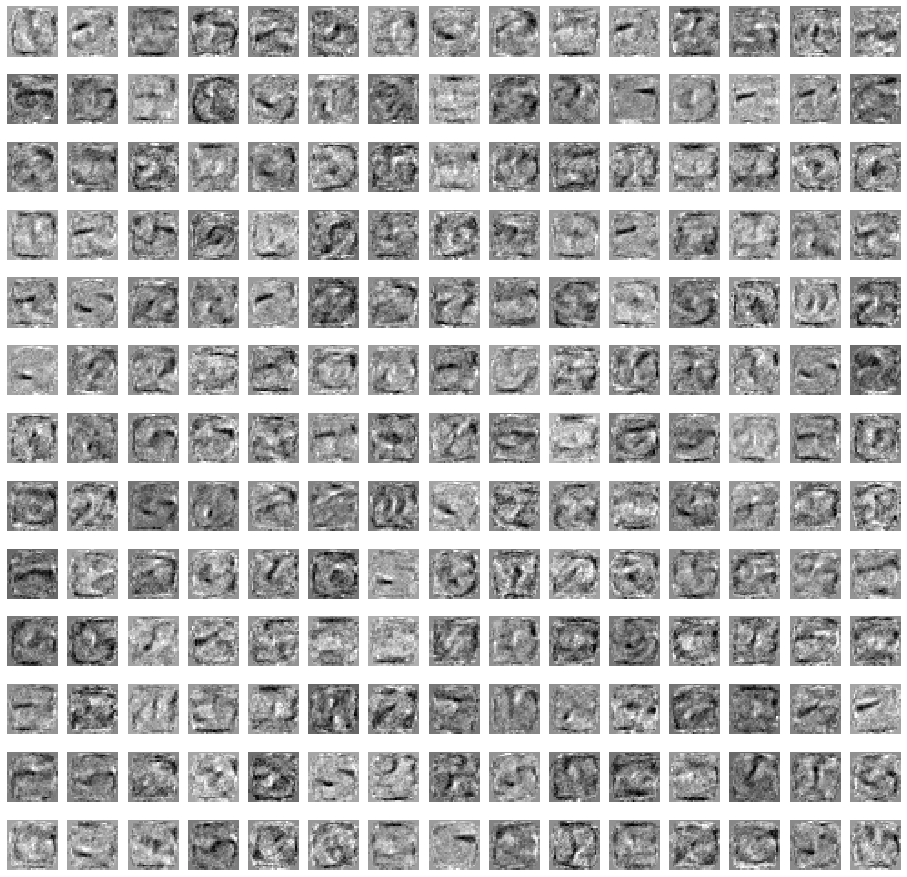

In [23]:
# Visualize the some of the weights of the first layer of the network.
def visualize_first_layer(net):
    W1 = net.params["W1"]
    W1 = W1.reshape(28, 28, -1).transpose(2, 0, 1)
    num = W1.shape[0]
    grid_width = min(15, num)
    grid_height = num // grid_width
    for _r in range(grid_height):
        for _c in range(grid_width):
            plt_idx = _r * grid_width + _c + 1
            img = W1[plt_idx]
            low, high = np.min(img), np.max(img)
            if high > low:
                img = 255.0 * (img - low) / (high - low)
            else:
                img *= 0
            plt.subplot(grid_height, grid_width, plt_idx)
            plt.imshow(img.astype("uint8"))
            plt.axis("off")

    plt.gcf().set_size_inches(16, 16)
    plt.show()

visualize_first_layer(nn_model)